In [ ]:
import collections
from datetime import datetime
import itertools
import logging
import multiprocessing
import os
import random

import keras
from keras import layers, models, optimizers
from keras.applications import VGG16
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import PIL
from PIL import ImageFilter
from PIL import Image
from scipy import ndimage, signal
from sklearn.metrics import confusion_matrix, accuracy_score
import tensorflow as tf

tf.get_logger().setLevel(logging.ERROR)

# The Problem

The problem is described in detail [here](https://www.aicrowd.com/challenges/ai-blitz-6/problems/chess-points). Given the image of a chess board, the side (piece color - B or W) having the greater number of aggregate piece points is to be provided as output.

In [ ]:
tf.test.is_gpu_available()

True

# Non-ML Solution

## Template Matching

### Helper functions

In [ ]:
def show_image(image_id=None, what='train'):
    """Show a random or requested image."""
    if image_id is None:
        all_files = os.listdir(what)
        img_file = random.sample(all_files, 1)[0]
        image_id, _ = os.path.splitext(img_file)
    
    label_df = pd.read_csv(f'{what}.csv')
    img = PIL.Image.open(os.path.join(os.getcwd(), what, f'{image_id}.jpg'))
    img = img.resize((256, 256))
    img_np = np.array(img)
    label = label_df[label_df['ImageID'] == int(image_id)].iloc[0, 1]
    return img, img_np, label, image_id

In [ ]:
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, "{} rows is not evenly divisble by {}".format(h, nrows)
    assert w % ncols == 0, "{} cols is not evenly divisble by {}".format(w, ncols)
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

### Step 1: Determine whether or not a piece is present on a block

Generate a first set of templates.  From training image 0 of [problem 3](https://www.aicrowd.com/challenges/ai-blitz-6/problems/chess-configuration), solution to which is posted [here](https://github.com/keyapandia123/aicrowd/blob/main/chess/chess_config.ipynb), select black and white pawn pieces, each on black (dark) background and white (light) background. Use these four blocks as templates for subsequent template matching.

Identify whether or not a piece is present on a block using template matching. As explained in the chess pieces template matching solution ([problem 1, approach 2](https://github.com/keyapandia123/aicrowd/blob/main/chess/chess_pieces.ipynb)), select correlation thresholds heuristically:
* Look at the max correlation values for the black and white piece templates when correlated with a background block and with a piece block
* Select a black correlation threshold for discriminating background from a (black) piece when correlating with the black piece template 
* Similarly select a white correlation threshold for discriminating background from a (white) piece when correlating with the white piece template

Selected thresholds are: black = 200 and white = 150

In [ ]:
def return_templates(to_print=False):
    """
    Return templates for black and white pieces.

    Use image 0 to pick out two black pieces (pawns) and two white pieces 
    (pawns) for template-matching. This is the first stage of template-matching 
    to determine whether or not a piece is present in a given block.
    """
    what='template'
    image_id=0
    img_template = PIL.Image.open(os.path.join(os.getcwd(), what, f'{image_id}.jpg'))
    img_template = img_template.resize((256, 256))
    img_np = np.array(img_template)
    
    imgbw_template = img_template.convert(mode='L')
    imgbw_np_template = np.array(imgbw_template)
    
    template_b1 = blockshaped(imgbw_np_template, 32, 32)[8]
    template_b2 = blockshaped(imgbw_np_template, 32, 32)[15]
    template_w1 = blockshaped(imgbw_np_template, 32, 32)[25]
    template_w2 = blockshaped(imgbw_np_template, 32, 32)[35]
    
    if to_print:
        plt.imshow(imgbw_np_template)
        
        fig = plt.figure()
        plt.subplot(2,2,1)
        plt.imshow(template_b1)
        plt.subplot(2,2,2)
        plt.imshow(template_b2)
        plt.subplot(2,2,3)
        plt.imshow(template_w1)
        plt.subplot(2,2,4)
        plt.imshow(template_w2)
            
            
    return template_b1, template_b2, template_w1, template_w2


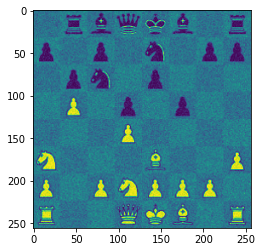

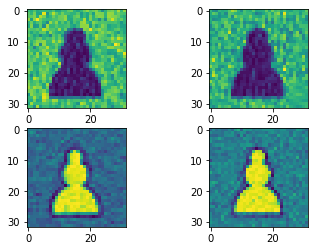

In [ ]:
template_b1, template_b2, template_w1, template_w2 = return_templates(to_print=True)

In [ ]:
def norm_corr(block, template):
    """
    Perform normalized 2D correlation.

    Subtract block mean from block and template mean from template before 
    correlating. Divide correlation output by block standard deviation and 
    template standard deviation.
    """
    return signal.correlate2d(block - np.mean(block), template - np.mean(template)) / (np.std(block) * np.std(template))

Consider training image with id=1

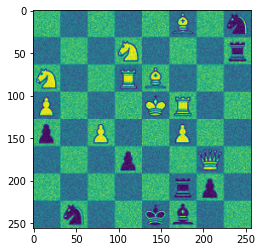

In [ ]:
img, img_np, label, image_id = show_image(1)
imgbw = img.convert(mode='L')
imgbw_np = np.array(imgbw)
plt.imshow(imgbw_np)

Consider a white piece from the above image, selected at random. Correlate this white piece with one of the black piece templates and one of the white piece templates. The correlation score with the white piece template exceeds the white correlation threshold (443.223 > 150), hence this white piece block gets detected as a piece.

Correlating a white piece with:
Black template:  184.83963389540105
White template:  443.22329376155585


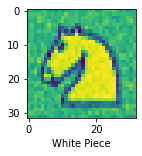

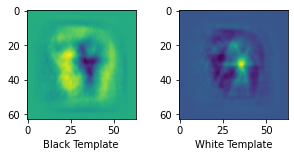

In [ ]:
out1 = norm_corr(blockshaped(imgbw_np, 32, 32)[16], template_b2)
out2 = norm_corr(blockshaped(imgbw_np, 32, 32)[16], template_w2)

fig = plt.figure(figsize=(2, 2))
plt.imshow(blockshaped(imgbw_np, 32, 32)[16])
plt.xlabel('White Piece')
fig = plt.figure(figsize=(5, 2))
plt.subplot(121)
plt.imshow(out1)
plt.xlabel('Black Template')
plt.subplot(122)
plt.imshow(out2)
plt.xlabel('White Template')

print("Correlating a white piece with:")
print("Black template: ", np.max(out1.flatten()))
print("White template: ", np.max(out2.flatten()))

Consider a black piece from the above image, selected at random. Correlate this black piece with one of the black piece templates and one of the white piece templates. The correlation score with the black piece template exceeds the black correlation threshold (927.591 > 200), hence this black piece block gets detected as a piece.

Correlating a black piece with:
Black template:  927.5916760106214
White template:  212.8521879395336


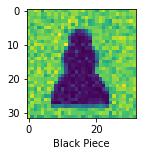

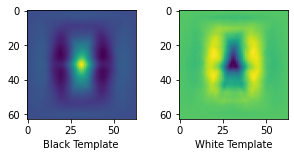

In [ ]:
out3 = norm_corr(blockshaped(imgbw_np, 32, 32)[32], template_b2)
out4 = norm_corr(blockshaped(imgbw_np, 32, 32)[32], template_w2)

fig = plt.figure(figsize=(2, 2))
plt.imshow(blockshaped(imgbw_np, 32, 32)[32])
plt.xlabel('Black Piece')
fig = plt.figure(figsize=(5, 2))
plt.subplot(121)
plt.imshow(out3)
plt.xlabel('Black Template')
plt.subplot(122)
plt.imshow(out4)
plt.xlabel('White Template')

print("Correlating a black piece with:")
print("Black template: ", np.max(out3.flatten()))
print("White template: ", np.max(out4.flatten()))

Now finally consider a background block from the above image, selected at random. Correlate this block with one of the black piece templates and one of the white piece templates. The correlation score with the neither template exceeds the respective correlation threshold (110.208 < 200 and 97.635 < 150), hence this block gets detected as a background block.

Correlating a background block with:
Black template:  110.20834384327063
White template:  97.63526514128785


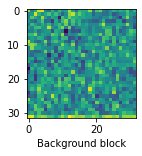

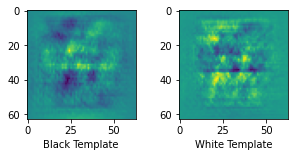

In [ ]:
out5 = norm_corr(blockshaped(imgbw_np, 32, 32)[8], template_b2)
out6 = norm_corr(blockshaped(imgbw_np, 32, 32)[8], template_w2)

fig = plt.figure(figsize=(2, 2))
plt.imshow(blockshaped(imgbw_np, 32, 32)[8])
plt.xlabel('Background block')
fig = plt.figure(figsize=(5, 2))
plt.subplot(121)
plt.imshow(out5)
plt.xlabel('Black Template')
plt.subplot(122)
plt.imshow(out6)
plt.xlabel('White Template')

print("Correlating a background block with:")
print("Black template: ", np.max(out5.flatten()))
print("White template: ", np.max(out6.flatten()))

### Step 2: Determine whether a detected piece is black or white

As explained in the chess pieces template matching solution (problem 1, approach 2), classify a detected piece as black or white
* Use the quantized and blurred image (as explained in problem 1, approach 1) of the block that has a piece 
* Count the number of white pixels vs. the black pixels in the center of the quantized block 
* Classify as black or white piece based on a majority counting heuristic. As shown in the images below, the center of the black pawn piece (after blurring and quantizing) has a majority of black pixels and the center of the white knight piece (after blurring and quantizing) has a majority of white pixels.

In [ ]:
#Thresholds to go with first quantization step
BLACK_TH1 = 10
WHITE_TH1 = 246

def quantize(imgbw_np):
    """
    Quantize the image into three values for black, white, and background.

    Setting three discrete values for each image pixel. One value for each 
    piece color and the third for the background.
    """
    new_img = imgbw_np.copy()

    new_img[imgbw_np < BLACK_TH1] = 0
    new_img[imgbw_np > WHITE_TH1] = 255
    new_img[(imgbw_np >= BLACK_TH1) & (imgbw_np <= WHITE_TH1)] = 128
    
    return new_img

In [ ]:
#Thresholds to go with second quantization step
BLACK_TH2 = 115
WHITE_TH2 = 135
    

def blur_and_quantize(imgbw_np, img=None, img_np=None):
    """
    Blur quantized image and then quantize the blurred image again.
    Different pixel intensity thresholds are used for the first and second quantization steps. 
    """
    
    new_img1 = imgbw_np.copy()
    new_img = quantize(imgbw_np)
    
    img = Image.fromarray(new_img)
    
    # use blurring
    img_blurred = img.filter(ImageFilter.GaussianBlur(radius=2))
    imgbw_np = np.array(img_blurred)
    
    new_img[imgbw_np < BLACK_TH2 ] = 0
    new_img[imgbw_np > WHITE_TH2] = 255
    new_img[(imgbw_np >= BLACK_TH2) & (imgbw_np <= WHITE_TH2)] = 128
    
    return new_img

In [ ]:
BL_CORR_TH = 200
WH_CORR_TH = 150

WHITE_TH3 = 9
BLACK_TH3 = 15

def vector_black_white_background_pieces(imgbw_np, new_img, center_only=False):
    """
    Classify each block as B piece, W piece, or background
    
    """
    no_of_blocks = 64
    w = 5
    h = w + 4
    
    x = []
    y = []
    
    template_b1, template_b2, template_w1, template_w2 = return_templates(to_print=False)
    for i in range(no_of_blocks):
        img_block_raw = blockshaped(imgbw_np, 32, 32)[i]
        img_block_quantized = blockshaped(new_img, 32, 32)[i]
        
        # First, detect via correlation (template-matching) whether there is a piece or not in a given block
        out1 = norm_corr(img_block_raw, template_b1)
        out2 = norm_corr(img_block_raw, template_b2)
        out3 = norm_corr(img_block_raw, template_w1)
        out4 = norm_corr(img_block_raw, template_w2)
        
        if (np.max(out1.flatten()) < BL_CORR_TH and 
            np.max(out2.flatten()) < BL_CORR_TH and 
            np.max(out3.flatten()) < WH_CORR_TH and 
            np.max(out4.flatten()) < WH_CORR_TH):
            y.append(0.0)  # Background block correlated with none of the four templates will meet the specified threshold
        
        # Second, if piece is present, detect using majority counting hueristic whether the piece is black or white
        else:
            if center_only:
                center = img_block_quantized[16-h:16+h, 16-w:16+w]
                block_dict = collections.Counter(center.flatten())
            else:
                block_dict = collections.Counter(img_block_quantized.flatten())
            
            
            if block_dict[255.0] > WHITE_TH3 or block_dict[255.0] > block_dict[0.0]: 
                y.append(1.0)
                
            elif block_dict[0.0] > BLACK_TH3 and block_dict[0.0] > block_dict[255.0]: 
                y.append(-1.0)
                
            else:
                y.append(0.0)
                
      
    x = np.array(x)
    x = np.expand_dims(x, -1)
    y = np.array(y)
    return x, y

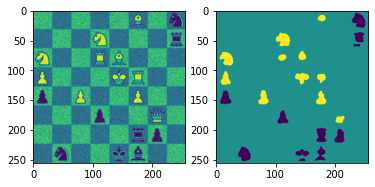

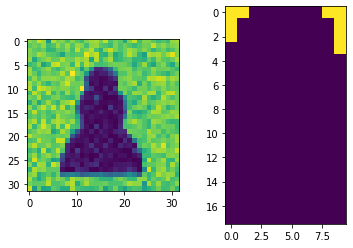

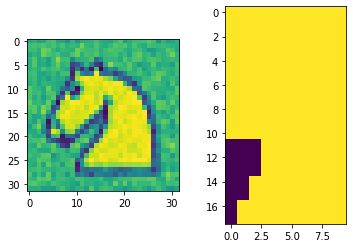

In [ ]:
new_img1 = blur_and_quantize(imgbw_np, img, img_np)
w = 5
h = w + 4
    
plt.subplot(121)
plt.imshow(imgbw_np)
plt.subplot(122)
plt.imshow(new_img1)

fig = plt.figure()
plt.subplot(121)
plt.imshow(blockshaped(imgbw_np, 32, 32)[32])
plt.subplot(122)
plt.imshow(blockshaped(new_img1, 32, 32)[32][16-h:16+h, 16-w:16+w])

fig = plt.figure()
plt.subplot(121)
plt.imshow(blockshaped(imgbw_np, 32, 32)[16])
plt.subplot(122)
plt.imshow(blockshaped(new_img1, 32, 32)[16][16-h:16+h, 16-w:16+w])


### Step 3: Determine the type of piece, given the piece color
Use a second stage of template matching to identify the type of piece given the color of the piece:

* Generate a second set of templates for black pieces - one for each kind of black piece ('k', 'p', 'n', 'b', 'r', 'q')
* Generate a third set of templates for white pieces - one for each kind of white piece ('K', 'P', 'N', 'B', 'R', 'Q')
* If a given piece was classified as a black piece, then correlate the piece block with each template from the second set (black templates) to identify the strongest correlation
* If a given piece was classified as a white piece, then correlate the piece block with each template from the third set (white templates) to identify the strongest correlation
* Assign predefined number of points to the identified piece (king=0, pawn=1, knight=3, bishop=3, rook=5, queen=9)

In [ ]:
def templates(to_print=False):
    """
    From image 0 of problem 3, select blocks having pieces corresponding to each piece type for each color (B and W)
    Piece types for each color are king, pawn, knight, bishop, rook, and queen
    Return these selected blocks as second and third sets of templates.
    This is the second stage of template-matching to determine the type of piece present in a block.
    
    """
    what='template'
    image_id=0
    train_img = PIL.Image.open(os.path.join(os.getcwd(), what, f'{image_id}.jpg'))
    train_img = train_img.resize((256, 256))
    img_np = np.array(train_img)
    
    imgbw = train_img.convert(mode='L')
    imgbw_np = np.array(imgbw)
    
    img_block = blockshaped(imgbw_np, 32, 32)
    
    black_templates = []
    black_string = ['k', 'p', 'n', 'b', 'r', 'q']
    black_points = [0, 1, 3, 3, 5, 9]
    white_templates = []
    white_string = ['K', 'P', 'N', 'B', 'R', 'Q']
    white_points = [0, 1, 3, 3, 5, 9]
    
    black_templates.append(img_block[4]) #King
    black_templates.append(img_block[15]) #Pawn
    black_templates.append(img_block[12]) #Knight
    black_templates.append(img_block[2]) #Bishop
    black_templates.append(img_block[1]) #Rook
    black_templates.append(img_block[3]) #Queen
    
    white_templates.append(img_block[60]) #King
    white_templates.append(img_block[48]) #Pawn
    white_templates.append(img_block[40]) #Knight
    white_templates.append(img_block[61]) #Bishop
    white_templates.append(img_block[56]) #Rook
    white_templates.append(img_block[59]) #Queen
    
    if to_print: 
        fig = plt.figure()
        for i in range(1, 7):
            plt.subplot(1, 6, i)
            plt.imshow(black_templates[i-1])
            plt.xlabel(black_string[i-1])
        
        fig = plt.figure()
        for i in range(1, 7):
            plt.subplot(1, 6, i)
            plt.imshow(white_templates[i-1])
            plt.xlabel(white_string[i-1])
    
    return black_templates, black_string, black_points, white_templates, white_string, white_points

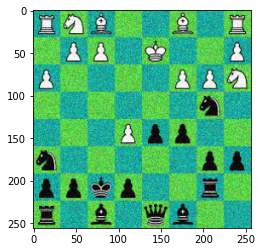

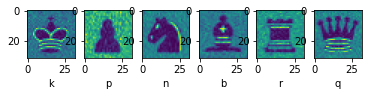

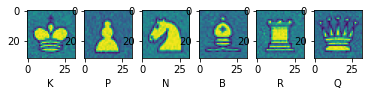

In [ ]:
train_img, img_np, label, image_id = show_image(image_id=0)

fig = plt.figure()
plt.imshow(train_img)


black_templates, black_string, black_points, white_templates, white_string, white_points = templates(to_print=True)

Consider a black bishop piece to be identified

Correlation values:  [333.0588669660742, 636.0326936665874, 521.3927329403791, 864.5719136990218, 528.7242369381325, 291.0571075835096]
Identified piece:  b
Identified piece points:  3


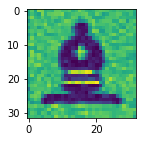

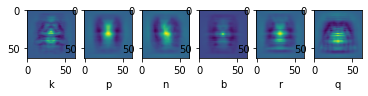

In [ ]:
img_block = blockshaped(imgbw_np, 32, 32)
test_block = img_block[61]
    
fig = plt.figure(figsize=(2, 2))
plt.imshow(test_block)

scores = [] 
fig = plt.figure()
for i in range(1, 7):    
    bt = black_templates[i-1] 
    wt = white_templates[i-1] 
    cor = norm_corr(test_block, bt)
    plt.subplot(1, 6, i)
    plt.imshow(cor)
    plt.xlabel(black_string[i-1])
    scores.append(np.max(np.abs(cor).flatten()))
print('Correlation values: ', scores)
print('Identified piece: ', black_string[np.argmax(np.array(scores))])
print('Identified piece points: ', black_points[np.argmax(np.array(scores))])

Consider a white queen piece to be identified

Correlation values:  [236.65837410915327, 379.6565554515778, 320.6498496561892, 308.6316095346737, 359.04248977583876, 865.2699147828648]
Identified piece:  Q
Identified piece points:  9


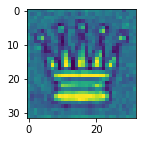

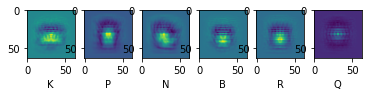

In [ ]:
test_block = img_block[46]
    
fig = plt.figure(figsize=(2, 2))
plt.imshow(test_block)

scores = [] 
fig = plt.figure()
for i in range(1, 7):    
    bt = black_templates[i-1] 
    wt = white_templates[i-1] 
    cor = norm_corr(test_block, wt)
    plt.subplot(1, 6, i)
    plt.imshow(cor)
    plt.xlabel(white_string[i-1])
    scores.append(np.max(np.abs(cor).flatten()))
print('Correlation values: ', scores)
print('Identified piece: ', white_string[np.argmax(np.array(scores))])
print('Identified piece points: ', white_points[np.argmax(np.array(scores))])

### Step 4: Generate total black score and total white score, and generate an output label corresponding to which color (B or W) has the higher of the two

* Generate total black score by adding all points per black piece
* Generate total white score by adding all points per white piece
* Compare the total black score and total white score 
* Output label 'black' if total black points are higher and vice versa

In [ ]:
def generate_score(im_id=None, what='train', to_plot=False):
    img, img_np, label, image_id = show_image(im_id, what)
    imgbw = img.convert(mode='L')
    imgbw_np = np.array(imgbw)
    
    new_img1 = blur_and_quantize(imgbw_np, img, img_np)
    if to_plot:
        plt.imshow(img)
        fig = plt.figure()
        plt.imshow(new_img1)
    
    new_img2 = quantize(imgbw_np)
    
    img_block = blockshaped(imgbw_np, 32, 32)
    
    
    _, y = vector_black_white_background_pieces(imgbw_np, new_img1, center_only=True)
    
    black_score = 0
    white_score = 0
    
    black_templates, black_string, black_points, white_templates, white_string, white_points = templates()
    bg_cnt = 0
    for block in range(64):
        if y[block] == 0.0: # background block
            bg_cnt += 1
            
        scores = []
        if y[block] != 0: # not background block
            test_block = np.squeeze(img_block[block, :, :])
            
            for i in range(1, 7):
                bt = black_templates[i-1] - np.mean(black_templates[i-1].flatten())
                wt = white_templates[i-1] - np.mean(white_templates[i-1].flatten())
                if y[block] == -1.0:  # if black piece, correlate with black templates
                    cor = norm_corr(test_block, bt)
                    
                elif y[block] == +1.0:  # if white piece, correlate with white templates
                    cor = norm_corr(test_block, wt)
                    
                scores.append(np.max(cor.flatten()))
                
        
            if y[block] == -1.0:
                black_score += black_points[np.argmax(np.array(scores))]
            elif y[block] == +1.0:
                white_score += white_points[np.argmax(np.array(scores))]
        
    if black_score > white_score:
        pred = 'black'
    else:
        pred = 'white'
        
    if to_plot:
        print("Black Score = ", black_score)
        print("White Score = ", white_score)
                 
    return label, pred
 

Black Score =  24
White Score =  16
True string =  black
Pred string =  black


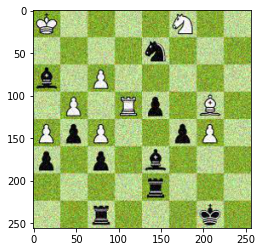

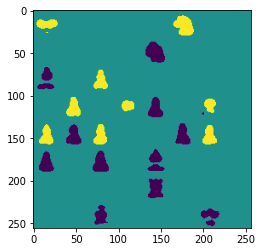

In [ ]:
true, predicted = generate_score(im_id=7, to_plot=True)
print('True string = ', true)
print('Pred string = ', predicted)

### Step 5: Repeat over multiple files and generate accuracy score

In [ ]:
def avg_accuracy_for_folder(what='train', to_print=True):
    true_labels = []
    mislabeled = []
    predicted_labels = []
    
    all_files = [x for x in os.listdir(what) if x.endswith('.jpg')]
    subset = random.sample(all_files, 20)

    for file in subset:
        image_id, _ = os.path.splitext(file)
        im_id = int(image_id)
        true, predicted = generate_score(im_id, what)
        true_labels.append(true)
        predicted_labels.append(predicted)
        if true != predicted:
            mislabeled.append(im_id)
            
    accuracy = accuracy_score(true_labels, predicted_labels)
    if to_print:
        print("Confusion matrix:")
        print(confusion_matrix(true_labels, predicted_labels, normalize='true'))
    return accuracy, mislabeled

In [ ]:
accuracy, mislabeled = avg_accuracy_for_folder(what='train', to_print=True)
print('Accuracy = ', accuracy)
print('Mislabeled = ', mislabeled)

Confusion matrix:
[[1. 0.]
 [0. 1.]]
Accuracy =  1.0
Mislabeled =  []


### An example of an image where the above approach fails to generate the correct score

Black Score =  30
White Score =  26
True String:  white
Pred String:  black


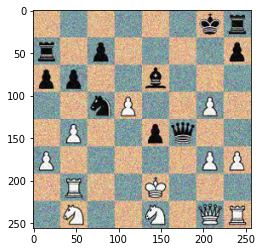

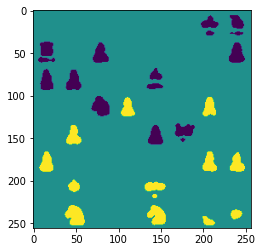

In [ ]:
true, predicted = generate_score(im_id=36141, to_plot=True)

print("True String: ", true)
print("Pred String: ", predicted)

# Using Neural Networks (ML)

## First Model 

Using RGB image data from entire image

In [ ]:
class DataGen1(keras.utils.Sequence):
    
    def __init__(self, what='train', batch_size=16, image_size=None, convert_to_bw=True):
        self.what = what
        self.batch_size = batch_size
        self.image_size = image_size
        self.convert_to_bw = convert_to_bw
        
        self.all_files = [x for x in os.listdir(self.what) if x.endswith('jpg')]
        random.shuffle(self.all_files)
        
    def __len__(self):    
        return int(np.ceil(len(self.all_files) / self.batch_size))
        
    def __getitem__(self, batch_num):
        x = []
        y = []
        all_files = self.all_files
        batch_size = self.batch_size
        for file in all_files[batch_num * batch_size: (batch_num + 1) * batch_size]:
            image_id, _ = os.path.splitext(file)
            im_id = int(image_id)
            img, img_np, label, image_id = show_image(im_id)
            if self.image_size:
                img = img.resize(self.image_size)
            
            if self.convert_to_bw:
                img = img.convert('L')
                img_np = np.expand_dims(np.array(img) / 255., -1)
            else:
                img_np = np.array(img) / 255.
                    
            x.append(img_np)
            y.append(0.0 if label == 'black' else 1.0)
        return np.array(x), np.array(y)
        
    def on_epoch_end(self):
        random.shuffle(self.all_files)

In [ ]:
train_gen = DataGen1('train', batch_size=16, convert_to_bw=False)
val_gen = DataGen1('val', batch_size=16, convert_to_bw=False)

In [ ]:
def build_model1():
    inp = keras.Input(shape=(256, 256, 3))
    x = keras.layers.Conv2D(9, (3, 3), activation='relu')(inp)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
    x = keras.layers.Flatten()(x)
    out = keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(1e-3),
        metrics=['accuracy'],
    )
    
    return model

In [ ]:
model = build_model1()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 254, 254, 9)       252       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 9)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 125, 16)      1312      
_________________________________________________________________
flatten_1 (Flatten)          (None, 250000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 250001    
Total params: 251,565
Trainable params: 251,565
Non-trainable params: 0
_____________________________________________________

In [ ]:
history = model.fit(train_gen, 
                    validation_data=val_gen, 
                    verbose=0,
                    epochs=750,
                    steps_per_epoch=8,
                    validation_freq=50)

0.9505000114440918

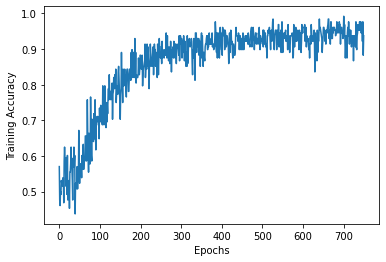

In [ ]:
plt.plot(history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')

np.max(history.history['val_accuracy'])

## Second Model 

Using two inputs into the ML model: the raw grayscale image and the points predicted for each block as a 64 element vector per image file 

In [ ]:
def generate_label_vector(im_id=None, what='train', to_plot=False):
    img, img_np, label, image_id = show_image(im_id, what)
    imgbw = img.convert(mode='L')
    imgbw_np = np.array(imgbw)
    
    new_img1 = blur_and_quantize(imgbw_np, img, img_np)
    if to_plot:
        plt.imshow(img)
        fig = plt.figure()
        plt.imshow(new_img1)
    
    new_img2 = quantize(imgbw_np)
    
    img_block = blockshaped(imgbw_np, 32, 32)
    
    
    _, y = vector_black_white_background_pieces(imgbw_np, new_img1, center_only=True)
    
    
    label_vector = []
    
    black_templates, black_string, black_points, white_templates, white_string, white_points = templates()
    
    for block in range(64):
        if y[block] == 0.0: # background block
            label_vector.append(0)
            
        scores = []
        if y[block] != 0: # not background block
            test_block = np.squeeze(img_block[block, :, :])
            
            for i in range(1, 7):
                bt = black_templates[i-1] - np.mean(black_templates[i-1].flatten())
                wt = white_templates[i-1] - np.mean(white_templates[i-1].flatten())
                if y[block] == -1.0:  # if black piece, correlate with black templates
                    cor = norm_corr(test_block, bt)
                    
                elif y[block] == +1.0:  # if white piece, correlate with white templates
                    cor = norm_corr(test_block, wt)
                    
                scores.append(np.max(cor.flatten()))
                
        
            if y[block] == -1.0:
                label_vector.append(-black_points[np.argmax(np.array(scores))])
            elif y[block] == +1.0:
                label_vector.append(white_points[np.argmax(np.array(scores))])
        
    return np.array(label_vector) / 10.

In [ ]:
def _parallel_fun(items):
    return generate_label_vector(*items)
        
    
class DataGen2(keras.utils.Sequence):
    
    def __init__(self, what='train', batch_size=16):
        self.what = what
        self.batch_size = batch_size
        
        self.all_files = [x for x in os.listdir(self.what) if x.endswith('jpg')]
        random.shuffle(self.all_files)
        
    def __len__(self):    
        return int(np.ceil(len(self.all_files) / self.batch_size))
        
    def __getitem__(self, batch_num):
        x = []
        #x1 = []
        y = []
        all_files = self.all_files
        batch_size = self.batch_size

            
        fn_inps = []
        for file in all_files[batch_num * batch_size: (batch_num + 1) * batch_size]:
            image_id, _ = os.path.splitext(file)
            im_id = int(image_id)
            img, img_np, label, image_id = show_image(im_id, what=self.what)
            img1 = img.convert('L')
            img1_np = np.array(img1)
            fn_inps.append((im_id, self.what))
            #x_labels = generate_label_vector(im_id, self.what)
            
            x.append(np.expand_dims(img1_np / 255., -1))
            
            #x1.append(x_labels) 
            y.append(0.0 if label == 'black' else 1.0)

        # Using parallel processing to speed up computation. 
        pool = multiprocessing.Pool(multiprocessing.cpu_count())
        results = pool.map_async(_parallel_fun, fn_inps)
        pool.close()
        pool.join()
        x1 = results.get()
        
        return (np.array(x), np.array(x1)), np.array(y)
        
    def on_epoch_end(self):
        random.shuffle(self.all_files)

In [ ]:
train_gen = DataGen2('train', batch_size=16)
val_gen = DataGen2('val', batch_size=16)

In [ ]:
def build_model2():
    img_inp = keras.Input(shape=(256, 256, 1), name='img')
    label_inp = keras.Input(shape=(64,), name='labels')
    x = keras.layers.Conv2D(16, (3, 3), activation='relu')(img_inp)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Concatenate()([x, label_inp])
   
    out = keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[img_inp, label_inp], outputs=out)
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(1e-3),
        metrics=['accuracy'],
    )
    
    return model

In [ ]:
model = build_model2()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 254, 254, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 127, 127, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 258064)       0           max_pooling2d[0][0]              
______________________________________________________________________________________________

In [ ]:
history = model.fit(train_gen, 
                    validation_data=val_gen, 
                    epochs=250,
                    steps_per_epoch=8,
                    verbose=0,
                    validation_freq=50,
                    validation_steps=10)

0.90625

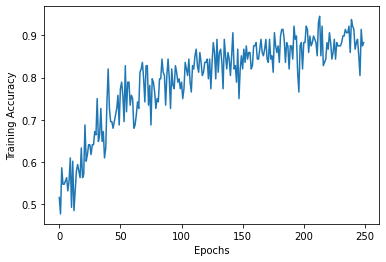

In [ ]:
plt.plot(history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')

np.max(history.history['val_accuracy'])

## Third Model 

Use the piece type identified by the non-ML (template-matching) approach described above to train the ML model to identify different piece types. 

* Convert an input RGB file into a grayscale image
* Divide / segment the grayscale image into 64 blocks
* Generate 64 batches of image data from each grayscale image (provide each block as a single batch of input)
* Each block of image data corresponds to a value in the 'y' vector produced using the non-ML approach above to identify each piece type
* Run the validation data through the ML model 
* Using a mapping from piece type to piece points, aggregate the number of points for each side (B and W) 

In [ ]:
def generate_score_vector(im_id=None, what='train', to_plot=False):
    img, img_np, label, image_id = show_image(im_id, what)
    imgbw = img.convert(mode='L')
    imgbw_np = np.array(imgbw)
    
    new_img1 = blur_and_quantize(imgbw_np, img, img_np)
    if to_plot:
        plt.imshow(img)
        fig = plt.figure()
        plt.imshow(new_img1)
    
    new_img2 = quantize(imgbw_np)
    
    img_block = blockshaped(imgbw_np, 32, 32)
    
    
    _, y = vector_black_white_background_pieces(imgbw_np, new_img1, center_only=True)
    
    black_score = 0
    white_score = 0
    
    ascii_vector = []
    
    black_templates, black_string, black_points, white_templates, white_string, white_points = templates()
    bg_cnt = 0
    for block in range(64):
        if y[block] == 0.0: # background block
            bg_cnt += 1
            ascii_vector.append('*')
            
        scores = []
        if y[block] != 0: # not background block
            test_block = np.squeeze(img_block[block, :, :])
            
            for i in range(1, 7):
                bt = black_templates[i-1] - np.mean(black_templates[i-1].flatten())
                wt = white_templates[i-1] - np.mean(white_templates[i-1].flatten())
                if y[block] == -1.0:  # if black piece, correlate with black templates
                    cor = norm_corr(test_block, bt)
                    
                elif y[block] == +1.0:  # if white piece, correlate with white templates
                    cor = norm_corr(test_block, wt)
                    
                scores.append(np.max(cor.flatten()))
                
        
            if y[block] == -1.0:
                black_score += black_points[np.argmax(np.array(scores))]
                ascii_vector.append(black_string[np.argmax(np.array(scores))])
            elif y[block] == +1.0:
                white_score += white_points[np.argmax(np.array(scores))]
                ascii_vector.append(white_string[np.argmax(np.array(scores))])
        
    y = []
    for char in ascii_vector:
        if char == '*':
            y.append(0)
        elif char.islower():
            for i in range(6):
                if char == black_string[i]:
                    y.append(i+1)
        else:
            for i in range(6):
                if char == white_string[i]:
                    y.append(i+7)
    
    
    return y

In [ ]:
class DataGen3(keras.utils.Sequence):
    
    def __init__(self, what='train', batch_size=64):
        self.what = what
        self.batch_size = 64
        
        self.all_files = [x for x in os.listdir(self.what) if x.endswith('jpg')]
        random.shuffle(self.all_files)
        
    def __len__(self):    
        return len(self.all_files)
        
    def __getitem__(self, batch_num):
        
        all_files = self.all_files
        
        file = all_files[batch_num]
        image_id, _ = os.path.splitext(file)
        im_id = int(image_id)
        img, img_np, label, image_id = show_image(im_id, what=self.what)
        img = img.convert('L')

        img_block = blockshaped(np.array(img), 32, 32)
        img_block = np.expand_dims(img_block, -1)
        

        x = img_block / 255.

        y = generate_score_vector(im_id, self.what)
        return x, np.array(y)
        
    def on_epoch_end(self):
        random.shuffle(self.all_files)

In [ ]:
train_gen = DataGen3('train', batch_size=64)
val_gen = DataGen3('val', batch_size=64)

In [ ]:
def build_model3():
    inp = keras.Input(shape=(32, 32, 1), name='img')
    
    x = keras.layers.Conv2D(32, (3, 3), activation='relu')(inp)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
  
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Flatten()(x)
    
    x = keras.layers.Dense(32, activation='relu')(x)
    out = keras.layers.Dense(13, activation='softmax')(x)
    
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(),
        optimizer=keras.optimizers.Adam(1e-3),
        metrics=['accuracy'],
    )
    
    return model

In [ ]:
model = build_model3()
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                7376

In [ ]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint('my_model.h5', save_best_only=True, monitor='val_accuracy'),
]

history = model.fit(train_gen, 
                    callbacks=callbacks_list, 
                    validation_data=val_gen, 
                    epochs=5,
                    verbose=1,
                    steps_per_epoch=100,
                    validation_steps=10,
                    validation_freq=5)

Epoch 1/5
100/100 [==============================] - 241s 2s/step - loss: 1.4553 - accuracy: 0.6698
Epoch 2/5
100/100 [==============================] - 243s 2s/step - loss: 0.1609 - accuracy: 0.9797
Epoch 3/5
100/100 [==============================] - 245s 2s/step - loss: 0.0281 - accuracy: 0.9986
Epoch 4/5
100/100 [==============================] - 242s 2s/step - loss: 0.0197 - accuracy: 0.9982
Epoch 5/5
100/100 [==============================] - 272s 3s/step - loss: 0.0429 - accuracy: 0.9962 - val_loss: 0.0063 - val_accuracy: 1.0000


1.0

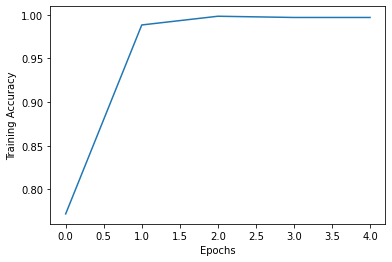

In [ ]:
plt.plot(history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')

np.max(history.history['val_accuracy'])

Run the validation data through the ML model and using a mapping from piece type to piece points, aggregate the number of points for each side (B and W)

In [ ]:
dd = {0: 0, # for background
         1: 0,
         2: -1,
         3: -3,
         4: -3,
         5: -5,
         6: -9,
         7: 0,
         8: 1,
         9: 3,
         10: 3,
         11: 5,
         12: 9}

def generate_score2(im_id=None, what='train', to_plot=False):
    """
    Given a random or specified image, prodvide the predicted label 
    (the side with the greater number of points).
    Run the ML model on the given image, convert the one-hot encoded output into a 
    a vector of points specified as values of the dictionary above. 
    Convert the list of predicted points into a total score for the given image.
    """
    img, img_np, label, image_id = show_image(im_id, what)
    img = img.convert('L')
    if to_plot:
        plt.imshow(img)

    img_block = blockshaped(np.array(img), 32, 32)
    img_block = np.expand_dims(img_block, -1)
    x = img_block / 255.

    model = keras.models.load_model('my_model.h5')

    y_pred_one_hot = model.predict(x)
    y_pred = np.argmax(y_pred_one_hot, axis=1)
    y_pred_points = [dd[x] for x in y_pred]
    
    total_score = np.sum(y_pred_points)
    
    if total_score < 0:
        return label, 'black'
                 
    return label, 'white'

True string =  black
Pred string =  black


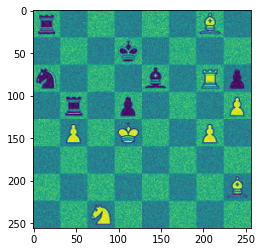

In [ ]:
true, predicted = generate_score2(im_id=None, to_plot=True)
print('True string = ', true)
print('Pred string = ', predicted)

In [ ]:
def avg_accuracy_for_folder2(what='train', to_print=True):
    true_labels = []
    mislabeled = []
    predicted_labels = []
    
    all_files = [x for x in os.listdir(what) if x.endswith('.jpg')]
    subset = random.sample(all_files, 1000)

    for file in subset:
        image_id, _ = os.path.splitext(file)
        im_id = int(image_id)
        true, predicted = generate_score2(im_id, what)
        true_labels.append(true)
        predicted_labels.append(predicted)
        if true != predicted:
            mislabeled.append(im_id)
            
    accuracy = accuracy_score(true_labels, predicted_labels)
    if to_print:
        print("Confusion matrix:")
        print(confusion_matrix(true_labels, predicted_labels, normalize='true'))
    return accuracy, mislabeled

Computing accuracy across multiple files in the validation and train folders 

In [ ]:
accuracy, mislabeled = avg_accuracy_for_folder2(what='val', to_print=True)
print('Accuracy = ', accuracy)
print('Mislabeled = ', mislabeled)

Confusion matrix:
[[1. 0.]
 [0. 1.]]
Accuracy =  1.0
Mislabeled =  []


In [ ]:
accuracy, mislabeled = avg_accuracy_for_folder2(what='train', to_print=True)
print('Accuracy = ', accuracy)
print('Mislabeled = ', mislabeled)

Confusion matrix:
[[1. 0.]
 [0. 1.]]
Accuracy =  1.0
Mislabeled =  []
